In [1]:
# import packages

import dask_awkward as dak
import numpy as np
from coffea.dataset_tools import preprocess
from distributed import Client
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp import ElectronTagNProbeFromNanoAOD, ElectronTagNProbeFromNTuples
from egamma_tnp.plot import plot_efficiency

In [2]:
# start client
client = Client()

/usr/local/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35673 instead
  warnings.warn(


In [3]:
# define datasets

fileset = {
    "samples": {
        "files": {
            "../root_files/Data_Run2023C_EGamma0_NANOAOD_22Sep2023_v1-v1_001.root": "Events",
        }
    }
}

print(fileset)

fileset_available, fileset_updates = preprocess(fileset, skip_bad_files=True, step_size=500_000)

{'samples': {'files': {'../root_files/Data_Run2023C_EGamma0_NANOAOD_22Sep2023_v1-v1_001.root': 'Events'}}}


In [4]:
# initialize tag and probe class

tnp = ElectronTagNProbeFromNanoAOD(
    fileset_available,
    filters=["HLT_Ele30_WPTight_Gsf"],
    filterbit=[1],
    cutbased_id = "cutBased >= 4",
    tags_pt_cut=30,
    use_sc_eta=True,
    tags_abseta_cut=2.50,
    probes_pt_cut=27,
    trigger_pt=[30],
)

egamma_tnp.binning.set("MET_pt_bins", np.linspace(0, 200, 21).tolist())
egamma_tnp.binning.set("luminosityBlock_bins", np.linspace(0, 1000, 11).tolist())
egamma_tnp.binning.set("tag_Ele_pt_bins", egamma_tnp.binning.get("pt_bins"))
egamma_tnp.binning.set("tag_Ele_eta_bins", egamma_tnp.binning.get("eta_bins"))
egamma_tnp.binning.set("el_pt_bins", egamma_tnp.binning.get("pt_bins"))
egamma_tnp.binning.set("el_eta_bins", egamma_tnp.binning.get("eta_bins"))
egamma_tnp.binning.set("Electron_pt_bins", egamma_tnp.binning.get("pt_bins"))

In [5]:
dak.necessary_columns(tnp.get_tnp_arrays(cut_and_count=False, vars=["Electron_pt", "tag_Ele_eta", "el_pt", "el_eta", "MET_pt", "luminosityBlock"]))

/usr/local/lib/python3.11/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


{'from-uproot-f87dc3631db195d07db8fe99ac23d811': frozenset({'Electron_charge',
            'Electron_cutBased',
            'Electron_deltaEtaSC',
            'Electron_eta',
            'Electron_mass',
            'Electron_phi',
            'Electron_pt',
            'HLT_Ele30_WPTight_Gsf',
            'MET_pt',
            'TrigObj_eta',
            'TrigObj_filterBits',
            'TrigObj_id',
            'TrigObj_phi',
            'TrigObj_pt',
            'luminosityBlock',
            'nElectron',
            'nTrigObj'})}

In [6]:
dak.necessary_columns(
    tnp.get_nd_tnp_histograms("HLT_Ele30_WPTight_Gsf", cut_and_count=True, vars=["tag_Ele_pt", "el_pt", "el_eta", "MET_pt", "luminosityBlock"])
)

{'from-uproot-f87dc3631db195d07db8fe99ac23d811': frozenset({'Electron_charge',
            'Electron_cutBased',
            'Electron_deltaEtaSC',
            'Electron_eta',
            'Electron_mass',
            'Electron_phi',
            'Electron_pt',
            'HLT_Ele30_WPTight_Gsf',
            'MET_pt',
            'TrigObj_eta',
            'TrigObj_filterBits',
            'TrigObj_id',
            'TrigObj_phi',
            'TrigObj_pt',
            'luminosityBlock',
            'nElectron',
            'nTrigObj'})}

In [7]:
# cut_and_count=True
out = tnp.get_tnp_arrays(cut_and_count=True, vars=["Electron_pt", "tag_Ele_eta", "el_pt", "el_eta", "MET_pt", "luminosityBlock"], compute=True)

# cut_and_count=False
#out = tnp.get_tnp_arrays(cut_and_count=False, vars=["Electron_pt", "tag_Ele_pt", "tag_Ele_eta", "el_pt", "el_eta", "MET_pt", "luminosityBlock"], compute=True)

/usr/local/lib/python3.11/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [8]:
out["samples"]

<Array [{Electron_pt: [...], ...}, ..., {...}] type='7391 * {Electron_pt: v...'>

In [12]:
out["samples"].Electron_pt
#out["samples"].pair_mass

<Array [[46.5, 38.2, 6.53], ..., [54.9, ...]] type='7391 * var * float32[pa...'>

In [13]:
out["samples"].el_pt

<Array [[38.2, 46.5], [...], ..., [37.7, 54.9]] type='7391 * var * float32[...'>

In [14]:
out = tnp.get_1d_pt_eta_phi_tnp_histograms(
    "HLT_Ele30_WPTight_Gsf",
    cut_and_count=True,
    vars=["el_pt", "el_eta", "el_phi"],
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap_loweta": [1.566, 2.0],
        "endcap_higheta": [2.0, 2.5],
    },
    plateau_cut=35,
    compute=True,
)

/usr/local/lib/python3.11/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [15]:
# cut_and_count=True
out = tnp.get_nd_tnp_histograms("HLT_Ele30_WPTight_Gsf", cut_and_count=True, vars=["tag_Ele_pt", "el_pt", "el_eta", "MET_pt", "luminosityBlock"], compute=True)

# cut_and_count=False
#out = tnp.get_nd_tnp_histograms("HLT_Ele30_WPTight_Gsf", cut_and_count=False, vars=["Electron_pt", "tag_Ele_pt", "tag_Ele_eta", "el_pt", "el_eta", "MET_pt", "luminosityBlock"], compute=True)

In [16]:
print(out)

{'samples': {'passing': Hist(
  Variable(array([  5. ,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  30. ,
        35. ,  40. ,  45. ,  50. ,  60. ,  80. , 100. , 150. , 200. ,
       250. , 300. , 350. , 400. ]), name='tag_Ele_pt', label='Tag_ele_pt'),
  Variable(array([  5. ,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  30. ,
        35. ,  40. ,  45. ,  50. ,  60. ,  80. , 100. , 150. , 200. ,
       250. , 300. , 350. , 400. ]), name='el_pt', label='El_pt'),
  Variable(array([-2.5   , -2.4   , -2.3   , -2.2   , -2.1   , -2.    , -1.9   ,
       -1.8   , -1.7   , -1.566 , -1.4442, -1.3   , -1.2   , -1.1   ,
       -1.    , -0.9   , -0.8   , -0.7   , -0.6   , -0.5   , -0.4   ,
       -0.3   , -0.2   , -0.1   ,  0.    ,  0.1   ,  0.2   ,  0.3   ,
        0.4   ,  0.5   ,  0.6   ,  0.7   ,  0.8   ,  0.9   ,  1.    ,
        1.1   ,  1.2   ,  1.3   ,  1.4442,  1.566 ,  1.7   ,  1.8   ,
        1.9   ,  2.    ,  2.1   ,  2.2   ,  2.3   ,  2.4   ,  2.5   ]), name='el_eta', label=

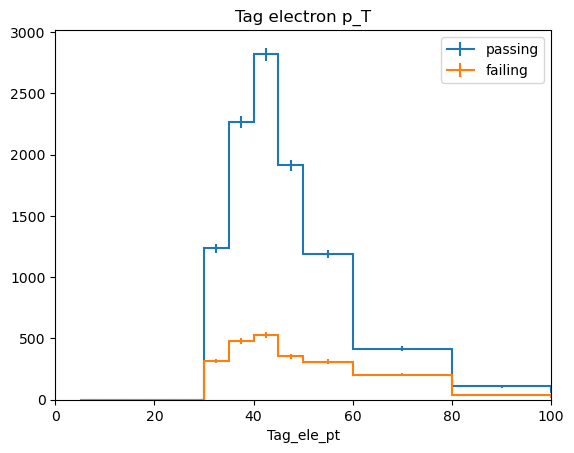

In [45]:
# Tag electron p_T
out["samples"]["passing"].project("tag_Ele_pt").plot(label="passing")
out["samples"]["failing"].project("tag_Ele_pt").plot(label="failing")
ax = plt.gca()
plt.title("Tag electron p_T")
plt.legend(loc="upper right")
ax.set_xlim([0.0, 100.0])
plt.show()

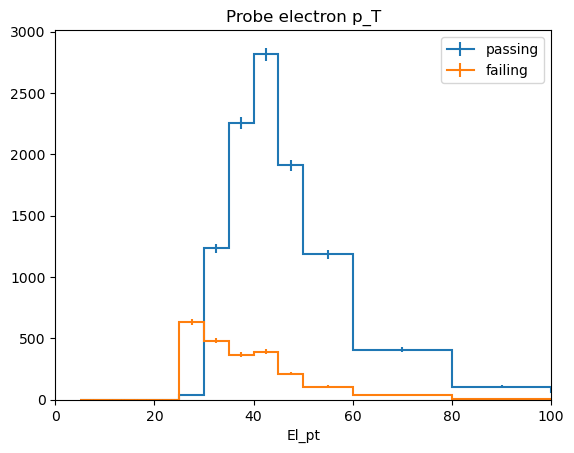

In [46]:
# Probe electron p_T
out["samples"]["passing"].project("el_pt").plot(label="passing")
out["samples"]["failing"].project("el_pt").plot(label="failing")
ax = plt.gca()
plt.title("Probe electron p_T")
plt.legend(loc="upper right")
ax.set_xlim([0.0, 100.0])
plt.show()

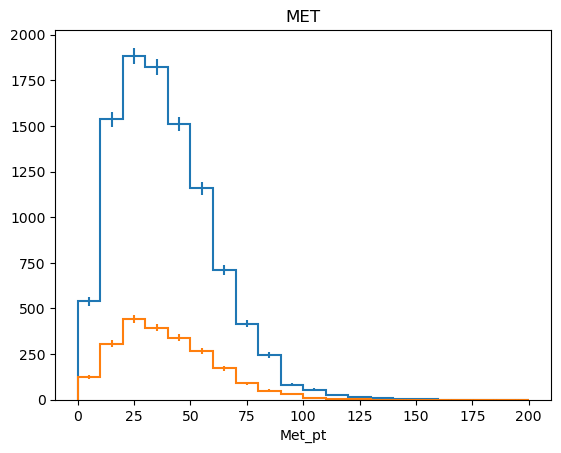

In [29]:
# MET p_T
out["samples"]["passing"].project("MET_pt").plot()
out["samples"]["failing"].project("MET_pt").plot()
plt.title("MET")
plt.show()

In [24]:
#out["samples"]["passing"].project("pair_mass").plot()
#out["samples"]["failing"].project("pair_mass").plot()
#plt.show()

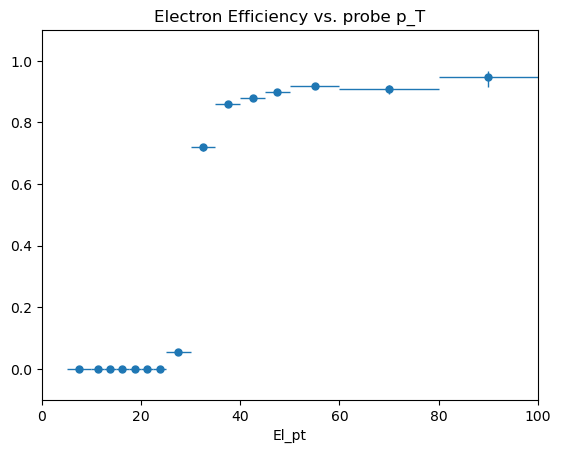

In [25]:
# efficiency vs. probe p_T
plot_efficiency(out["samples"]["passing"].project("el_pt"), out["samples"]["failing"].project("el_pt"))
plt.xlim(0.0, 100.0)
plt.ylim(-0.1, 1.1)
plt.title("Electron Efficiency vs. probe p_T")
plt.show()

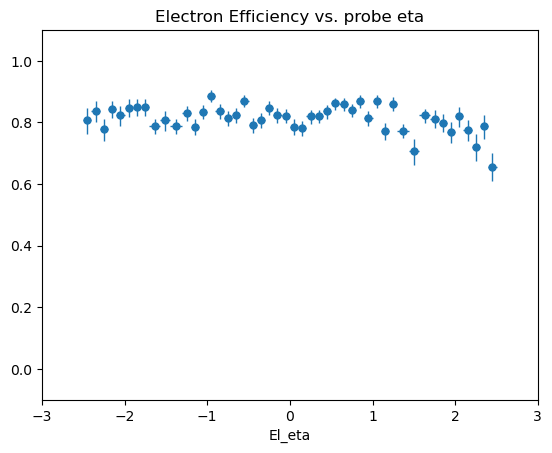

In [26]:
# efficiency vs. probe eta
plot_efficiency(out["samples"]["passing"].project("el_eta"), out["samples"]["failing"].project("el_eta"))
plt.xlim(-3.0, 3.0)
plt.ylim(-0.1, 1.1)
plt.title("Electron Efficiency vs. probe eta")
plt.show()